# Nextail Test 

In [1]:
#! pip install pmdarima

In [59]:
import pandas as pd
from numpy import log
import datetime as dt
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as mse

### Current Code:

In [3]:
def forecast_sales(start_date: datetime, end_date: datetime, sales_data: pd.DataFrame):

    days_to_forecast = (end_date - start_date).days
    mean_daily_sales = sales_data[sales_data['date'] < start_date]['sales'].mean()
    return mean_daily_sales * days_to_forecast

In [4]:
def calculate_new_order (order_date: datetime, lead_time_days: int, days_to_next_order: int, 
                         sales_data: pd.DataFrame, current_stock_level: int, stock_in_transit: int):
    
    arrival_date = order_date + timedelta(days=lead_time_days)
    next_arrival_date = order_date + timedelta(days=days_to_next_order + lead_time_days)
    
    forecast_leadtime = forecast_sales(order_date, arrival_date, sales_data)
    estimated_stock_at_arrival = current_stock_level - forecast_leadtime + stock_in_transit 
    
    forecast_planning_horizon = forecast_sales(arrival_date,next_arrival_date, sales_data)
    order = max(0,forecast_planning_horizon - estimated_stock_at_arrival)
    return order

### Calculate Reordering


In [46]:
order_date = datetime(2020,6,1)
lead_time_days = 90
days_to_next_order = 30
current_stock_level = 400
stock_in_transit = 600

In [6]:
sales_data = pd.read_csv('sales_data.csv',parse_dates=['date'])

In [7]:
calculate_new_order (order_date=order_date, 
                   lead_time_days=lead_time_days, 
                   days_to_next_order=days_to_next_order, 
                   sales_data=sales_data, 
                   current_stock_level=current_stock_level, 
                   stock_in_transit=stock_in_transit)


186.0598684820378

## Below is the improvement proposal for the problem 'Rewrite sunglasses for an online retailer' and the analysis developed to achieve it.

### Exploratory Data Analysis 

In [8]:
sales_data = sales_data.set_index(keys = 'date')
sales_data.head()

,sales
date,
2016-06-01,12
2016-06-02,22
2016-06-03,19
2016-06-04,20
2016-06-05,5


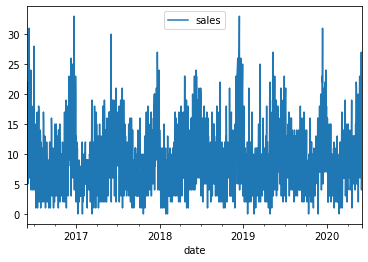

In [9]:
sales_data.plot()
plt.show()

We can observe that there is a seasonality associated with the data. We will apply a Dickey-Fuller Test for to verify the stationarity of the series.

### Dickey-Fuller Test

In [10]:
X = sales_data.sales
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.626367
p-value: 0.000001
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary. According to the results of the test, we can reject the null hypothesis, that means that the series has no unit root, and in turn that the time series is **stationary** i.e. the series doesn't have time-dependent structure.

# MODELO ARIMA

To attempt to improve the forecast function result, and knowing that the data series is stationary, we will use an Arima model that allows us to capture the temporal structure in the data series, with which we would expect to have a better fit.

### TRAIN - TEST

For the train-test segmentation, the model will be trained with a time window of nine months and it will be tested with the last three months of the series.

In [22]:
date0 = datetime(2019, 6, 1)
date1 = datetime(2020, 3, 1)

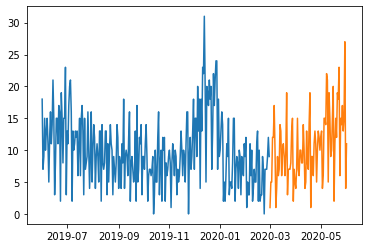

In [23]:
train = sales_data[(date0 <= sales_data.index) & (sales_data.index < date1)]
test = sales_data[date1 <= sales_data.index]
plt.plot(train)
plt.plot(test)

### Definición Modelo ARIMA

We will use the auto_arima function to find the parameters of the model that best fit the behavior of the data.

In [24]:
stepwise_model = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)


In [25]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  274
Model:             SARIMAX(1, 1, 2)x(2, 1, [], 12)   Log Likelihood                -828.198
Date:                             Sun, 07 Feb 2021   AIC                           1668.396
Time:                                     10:55:33   BIC                           1689.783
Sample:                                          0   HQIC                          1676.993
                                             - 274                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7875      0.084      9.405      0.000       0.623       0.952
ma.L1         -1.7683      0.075    -23.657      0.000      -1.915      -1.622
ma.L2          0.8223      0.064     12.798      0.000       0.696       0.948
ar.S.L12      -0.7832      0.073    -10.703      0.000      -0.927      -0.640
ar.S.L24      -0.3454      0.067     -5.168      0.000      -0.476      -0.214
sigma2        32.2843      2.551     12.656      0.000      27.284      37.284
===================================================================================
Ljung-Box (Q):                      403.65   Jarque-Bera (JB):                15.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.52
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Prediction

In [26]:
prediction_model = pd.DataFrame(stepwise_model.predict(n_periods = test.shape[0]), index = test.index, columns = ['predicted'])

C:\Users\dayan\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Unrecognized location 'Left corner'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  """


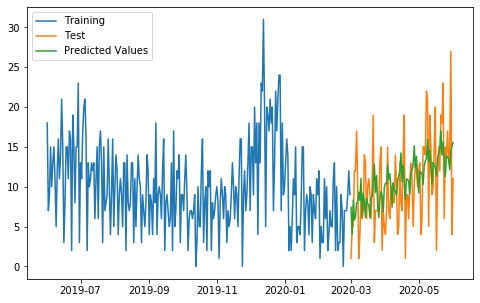

In [27]:
plt.figure(figsize = (8,5))
plt.plot(train, label = 'Training')
plt.plot(test, label = 'Test')
plt.plot(prediction_model, label = 'Predicted Values')
plt.legend(loc = 'Left corner')
plt.show()

### Metric

In [63]:
test['predicted_sales'] = prediction_model
print('MAE: ',mae(test['sales'], test['predicted_sales']))
print('MSE: ',mse(test['sales'], test['predicted_sales']))
print('RMSE: ', mse(test['sales'], test['predicted_sales'])**(0.5))

MAE:  4.029948212777635
MSE:  24.027445689607582
RMSE:  4.901779849157608


C:\Users\dayan\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Comparing Results

Once the arima model has been chosen, the results of the model, the forecast function and the real data in the months that were taken in the set of trains will be compared, this to evaluate if the arima model really improves the prediction.

In [29]:
sales_data_orig = pd.read_csv('sales_data.csv',parse_dates=['date'])

In [30]:
def comparing_results(start_date, end_date, prediction_data):
    # Real Sales
    real_sales = sales_data_orig[(start_date <= sales_data_orig.date) & (
        sales_data_orig.date < end_date)]
    # Mean model Sales
    mean_model = forecast_sales(start_date, end_date, sales_data_orig)
    # Results
    results = pd.DataFrame({'Real': real_sales.sales.sum(),
                            'Predicted': prediction_data,
                            'Mean_model': mean_model},
                           columns=['Real', 'Predicted', 'Mean_model'],
                           index=[start_date])
    if start_date >= datetime(2020, 6, 1):
        results = results[['Predicted', 'Mean_model']]
    return results

### 1. Test Months

In [31]:
prediction_value = prediction_model[(datetime(2020, 3, 1) <= prediction_model.index) & (
        prediction_model.index < datetime(2020, 4, 1))].predicted.sum()
comparing_results(datetime(2020, 3, 1), datetime(2020, 4, 1), prediction_value)

,Real,Predicted,Mean_model
2020-03-01,261,255.5126,305.108839


In [33]:
prediction_value = prediction_model[(datetime(2020, 4, 1) <= prediction_model.index) & (
        prediction_model.index < datetime(2020, 6, 1))].predicted.sum()
comparing_results(datetime(2020, 4, 1), datetime(2020, 6, 1), prediction_value)

,Real,Predicted,Mean_model
2020-04-01,705,739.280328,598.453571


In [32]:
prediction_value = prediction_model[(datetime(2020, 5, 1) <= prediction_model.index) & (
        prediction_model.index < datetime(2020, 6, 1))].predicted.sum()
comparing_results(datetime(2020, 5, 1), datetime(2020, 6, 1), prediction_value)

,Real,Predicted,Mean_model
2020-05-01,426,406.404228,303.8


### 2. Calculate New Reorder

With the previous results we can see that the model is a good option to improve the problem. Now we will recalculate the order for the next month.

In [64]:
def new_forcast_arima(date1, date2):
    total_days = (date2- datetime(2020, 6, 1)).days
    dates_prediction = [datetime(2020, 6, 1) + timedelta(days=i) for i in range(total_days)]
    prediction_values = pd.DataFrame(stepwise_model.predict(n_periods=len(
        dates_prediction)), index=dates_prediction, columns=['predicted'])
    prediction_values = prediction_values[(date1<= prediction_values.index)
                                          & (prediction_values.index < date2)]
    prediction_total = prediction_values.predicted.sum()
    return prediction_total

def new_calculate_new_order(order_date: datetime, lead_time_days: int, days_to_next_order: int, 
                         sales_data: pd.DataFrame, current_stock_level: int, stock_in_transit: int):
    
    arrival_date = order_date + timedelta(days=lead_time_days)
    next_arrival_date = order_date + timedelta(days=days_to_next_order + lead_time_days)
    
    forecast_leadtime = new_forcast_arima(order_date, arrival_date)
    estimated_stock_at_arrival = current_stock_level - forecast_leadtime + stock_in_transit 
    
    forecast_planning_horizon = new_forcast_arima(arrival_date, next_arrival_date)
    order = max(0,forecast_planning_horizon - estimated_stock_at_arrival)
    return order

First we see what the sales forecast would be for the following month with the two functions.

In [65]:
prediction_values1 = new_forcast_arima(datetime(2020, 6, 1), datetime(2020, 7, 1))
comparing_results(datetime(2020, 6, 1), datetime(2020, 7, 1), prediction_values1)

,Predicted,Mean_model
2020-06-01,245.652361,296.50924


In [66]:
new_calculate_new_order (order_date=order_date, 
                   lead_time_days=lead_time_days, 
                   days_to_next_order=days_to_next_order, 
                   sales_data=sales_data, 
                   current_stock_level=current_stock_level, 
                   stock_in_transit=stock_in_transit)

439.16651307489605

With this we obtain that the amount of sunglasses that we should order for the next month is 439.16

### Backtest

A small backtest analysis was carried out to see if the model had good performance in the previous months and thus see its performance.

In [54]:
def backtest_arima(date1, date2):
    date0 = date1 - timedelta(days=(date2-date1).days*3)
    train = sales_data[(date0 <= sales_data.index)
               & (sales_data.index < date1)]
    test = sales_data[(date1 <= sales_data.index)
               & (sales_data.index < date2)]
    model_backtest = auto_arima(train, start_p=1, start_q=1,
                                max_p=3, max_q=3, m=12,
                                start_P=0, seasonal=True,
                                d=1, D=1,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                               return_valid_fits = False)
    prediction = pd.DataFrame(model_backtest.predict(
        n_periods=test.shape[0]), index=test.index, columns=['predicted'])
    prediction_value = prediction.predicted.sum()
    return prediction_value

In [55]:
prediction_backtest = backtest_arima(datetime(2018, 12, 1), datetime(2019, 1, 1))

In [57]:
comparing_results(datetime(2018, 12, 1), datetime(2019, 1, 1), prediction_backtest)

,Real,Predicted,Mean_model
2018-12-01,580,434.392518,298.761227


# Conclusion and Future Work

For the correct development and implementation of the model, these points could be considered:

- Do a test-train-validation division in more detail, taking into account the temporal structure of the data, that is, generating the sets in chronological order and varying their size.
- The data could be grouped by month and the analysis made with this approach, it could be seen if in this way it is possible to take into account a greater temporality.
- In the analysis, an approach was made to the backtest by means of the following function, this analysis could be done in greater detail so that it can provide us with more data to our model.
- The parameter of the arima model could be chosen with a more detailed analysis with the corresponding correlation graph.